## Import libs

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.data import Dataset
import seaborn as sns


from util import metrics
from models.zhang.models import UnfairLogisticRegression
from util.evaluation import *
from util.load_data import load_data

## Preliminaries

In [2]:
batch_size = 64
epochs = 1
lr = 0.001
opt = Adam(learning_rate=lr)

In [3]:
header = "model_name", "clas_acc", "dp", "deqodds", "deqopp", "trade_dp", "trade_deqodds", "trade_deqopp", "TN_a0", "FP_a0", "FN_a0", "TP_a0", "TN_a1", "FP_a1", "FN_a1", "TP_a1"
results = []

test_loop = 1

## Load data

In [4]:
data_name = 'adult'

In [5]:
x_train, y_train, a_train = load_data(data_name, 'train')
raw_data = (x_train, y_train, a_train)

In [6]:
xdim = x_train.shape[1]
ydim = y_train.shape[1]
adim = a_train.shape[1]
zdim = 8

In [7]:
train_data = Dataset.from_tensor_slices((x_train, y_train, a_train))
train_data = train_data.batch(batch_size, drop_remainder=True)
train_data

<BatchDataset shapes: ((64, 112), (64, 1), (64, 1)), types: (tf.float64, tf.float64, tf.float64)>

In [8]:
x_valid, y_valid, a_valid = load_data(data_name, 'valid')

valid_data = Dataset.from_tensor_slices((x_valid, y_valid, a_valid))
valid_data = valid_data.batch(batch_size, drop_remainder=True)

In [9]:
x_test, y_test, a_test = load_data(data_name, 'test')

test_data = Dataset.from_tensor_slices((x_test, y_test, a_test))
test_data = test_data.batch(batch_size, drop_remainder=True)

## Train loop

In [10]:
def train(model, X, Y, A, optimizer):
    clas_vars = [model.clas.W, model.b]
    
    with tf.GradientTape() as clas_tape:
        
        model(X, Y, A)        
        clas_loss = model.clas_loss

    dWLp = clas_tape.gradient(clas_loss, clas_vars)
    optimizer.apply_gradients(zip(dWLp, clas_vars))

In [11]:
def train_loop(model, train_dataset, epochs, opt=None):
    dataset_size = tf.data.experimental.cardinality(train_dataset).numpy()
    print("> Epoch | Class Loss | Class Acc")

    if opt is not None:
        optimizer = opt
        decay4epoch = False
    else:
        decay4epoch = True
    
    for epoch in range(epochs):
        Y_hat = None
        clas_acc = 0

        if decay4epoch:
            lr = 0.001/(epoch+1)
            optimizer = Adam(learning_rate=lr)
        
        for X, Y, A in train_dataset:
            
            r = train(model, X, Y, A, optimizer)
            if r:
                print('parou')
                print(model.clas_loss)
                break

            Y_hat = model.Y_hat

            clas_acc += metrics.accuracy(Y, tf.math.round(Y_hat))

        clas_loss = model.clas_loss
        clas_acc = clas_acc / dataset_size

        
    
        print("> {} | {} | {}".format(
            epoch+1, 
            clas_loss, 
            clas_acc))

## Testing

In [12]:
for i in range(test_loop):

    model = UnfairLogisticRegression(xdim, batch_size)
    ret = train_loop(model, train_data, epochs)
    Y, A, Y_hat = evaluation(model, valid_data)
    
    clas_acc, dp, deqodds, deqopp, confusion_matrix, metrics_a0, metrics_a1  = compute_metrics(Y, Y_hat, A, adim=adim)
    
    fair_metrics = (dp, deqodds, deqopp)
    
    tradeoff = []
    
    for fair_metric in fair_metrics:
        tradeoff.append(compute_tradeoff(clas_acc, fair_metric))
    
    result = ['UnfairLR-decay', clas_acc, dp, deqodds, deqopp, tradeoff[0], tradeoff[1], tradeoff[2]] + metrics_a0 + metrics_a1

    results.append(result)

> Epoch | Class Loss | Class Acc
> 1 | 0.5871778726577759 | 0.5937085543766578
> Evaluation
> Class Acc = 0.4988364361702128
> DP | DEqOdds | DEqOpp
> 0.6877342462539673 | 0.7449854463338852 | 0.8771103024482727
> Confusion Matrix 
TN: 2800.0 | FP: 1758.0 
FN: 1257.0 | TP: 201.0
> Confusion Matrix for A = 0 
TN: 17.0 | FP: 0.0 
FN: 87.0 | TP: 2.0
> Confusion Matrix for A = 1 
TN: 2783.0 | FP: 1758.0 
FN: 1170.0 | TP: 199.0


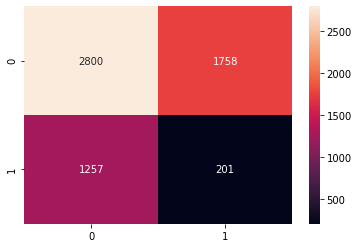

In [13]:
sns.heatmap(confusion_matrix, annot=True, fmt='g')

In [14]:
for i in range(test_loop):
    opt = Adam(learning_rate=lr)

    model = UnfairLogisticRegression(xdim, batch_size)
    ret = train_loop(model, train_data, epochs)
    Y, A, Y_hat = evaluation(model, valid_data)
    
    clas_acc, dp, deqodds, deqopp, confusion_matrix, metrics_a0, metrics_a1  = compute_metrics(Y, Y_hat, A, adim=adim)
    
    fair_metrics = (dp, deqodds, deqopp)
    
    tradeoff = []
    
    for fair_metric in fair_metrics:
        tradeoff.append(compute_tradeoff(clas_acc, fair_metric))
    
    result = ['UnfairLR', clas_acc, dp, deqodds, deqopp, tradeoff[0], tradeoff[1], tradeoff[2]] + metrics_a0 + metrics_a1

    results.append(result)

> Epoch | Class Loss | Class Acc
> 1 | 0.5871778726577759 | 0.5937085543766578
> Evaluation
> Class Acc = 0.4988364361702128
> DP | DEqOdds | DEqOpp
> 0.6877342462539673 | 0.7449854463338852 | 0.8771103024482727
> Confusion Matrix 
TN: 2800.0 | FP: 1758.0 
FN: 1257.0 | TP: 201.0
> Confusion Matrix for A = 0 
TN: 17.0 | FP: 0.0 
FN: 87.0 | TP: 2.0
> Confusion Matrix for A = 1 
TN: 2783.0 | FP: 1758.0 
FN: 1170.0 | TP: 199.0


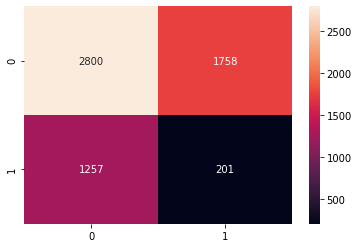

In [15]:
sns.heatmap(confusion_matrix, annot=True, fmt='g')

## Saving into DF then CSV

In [16]:
result_df = pd.DataFrame(results, columns=header)
result_df

,model_name,clas_acc,dp,deqodds,deqopp,trade_dp,trade_deqodds,trade_deqopp,TN_a0,FP_a0,FN_a0,TP_a0,TN_a1,FP_a1,FN_a1,TP_a1
0,UnfairLR-decay,0.498836,0.687734,0.744985,0.87711,0.578249,0.597555,0.635976,17.0,0.0,87.0,2.0,2783.0,1758.0,1170.0,199.0
1,UnfairLR,0.498836,0.687734,0.744985,0.87711,0.578249,0.597555,0.635976,17.0,0.0,87.0,2.0,2783.0,1758.0,1170.0,199.0


In [17]:
result_df.to_csv(f'adult-result/unfair_lr-{epochs}.csv')